<a href="https://colab.research.google.com/github/wodamba-alt/Bottle-fill-yollo-11-training/blob/main/notebooks/train-yolo11-object-detection-on-custom-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Apr 21 08:34:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [3]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.2/112.6 GB disk)


## Fine-tune YOLO11 on custom dataset

In [4]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

workspace = rf.workspace("davidbottle-defect-inspection")
project = workspace.project("bottle-cap-and-fill-defects")
version = project.version(2)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to bottle-cap-and-fill-defects-2 in yolov11:: 100%|██████████| 1624/1624 [00:00<00:00, 3862.17it/s]


## Custom Training

In [6]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=100 imgsz=640 plots=True

/content
New https://pypi.org/project/ultralytics/8.3.112 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/bottle-cap-and-fill-defects-2/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [7]:
!ls runs/detect/train/

args.yaml					    results.png
confusion_matrix_normalized.png			    train_batch0.jpg
confusion_matrix.png				    train_batch1.jpg
events.out.tfevents.1745224798.1d5ee36286ed.3000.0  train_batch2.jpg
F1_curve.png					    val_batch0_labels.jpg
labels_correlogram.jpg				    val_batch0_pred.jpg
labels.jpg					    val_batch1_labels.jpg
P_curve.png					    val_batch1_pred.jpg
PR_curve.png					    val_batch2_labels.jpg
R_curve.png					    val_batch2_pred.jpg
results.csv					    weights


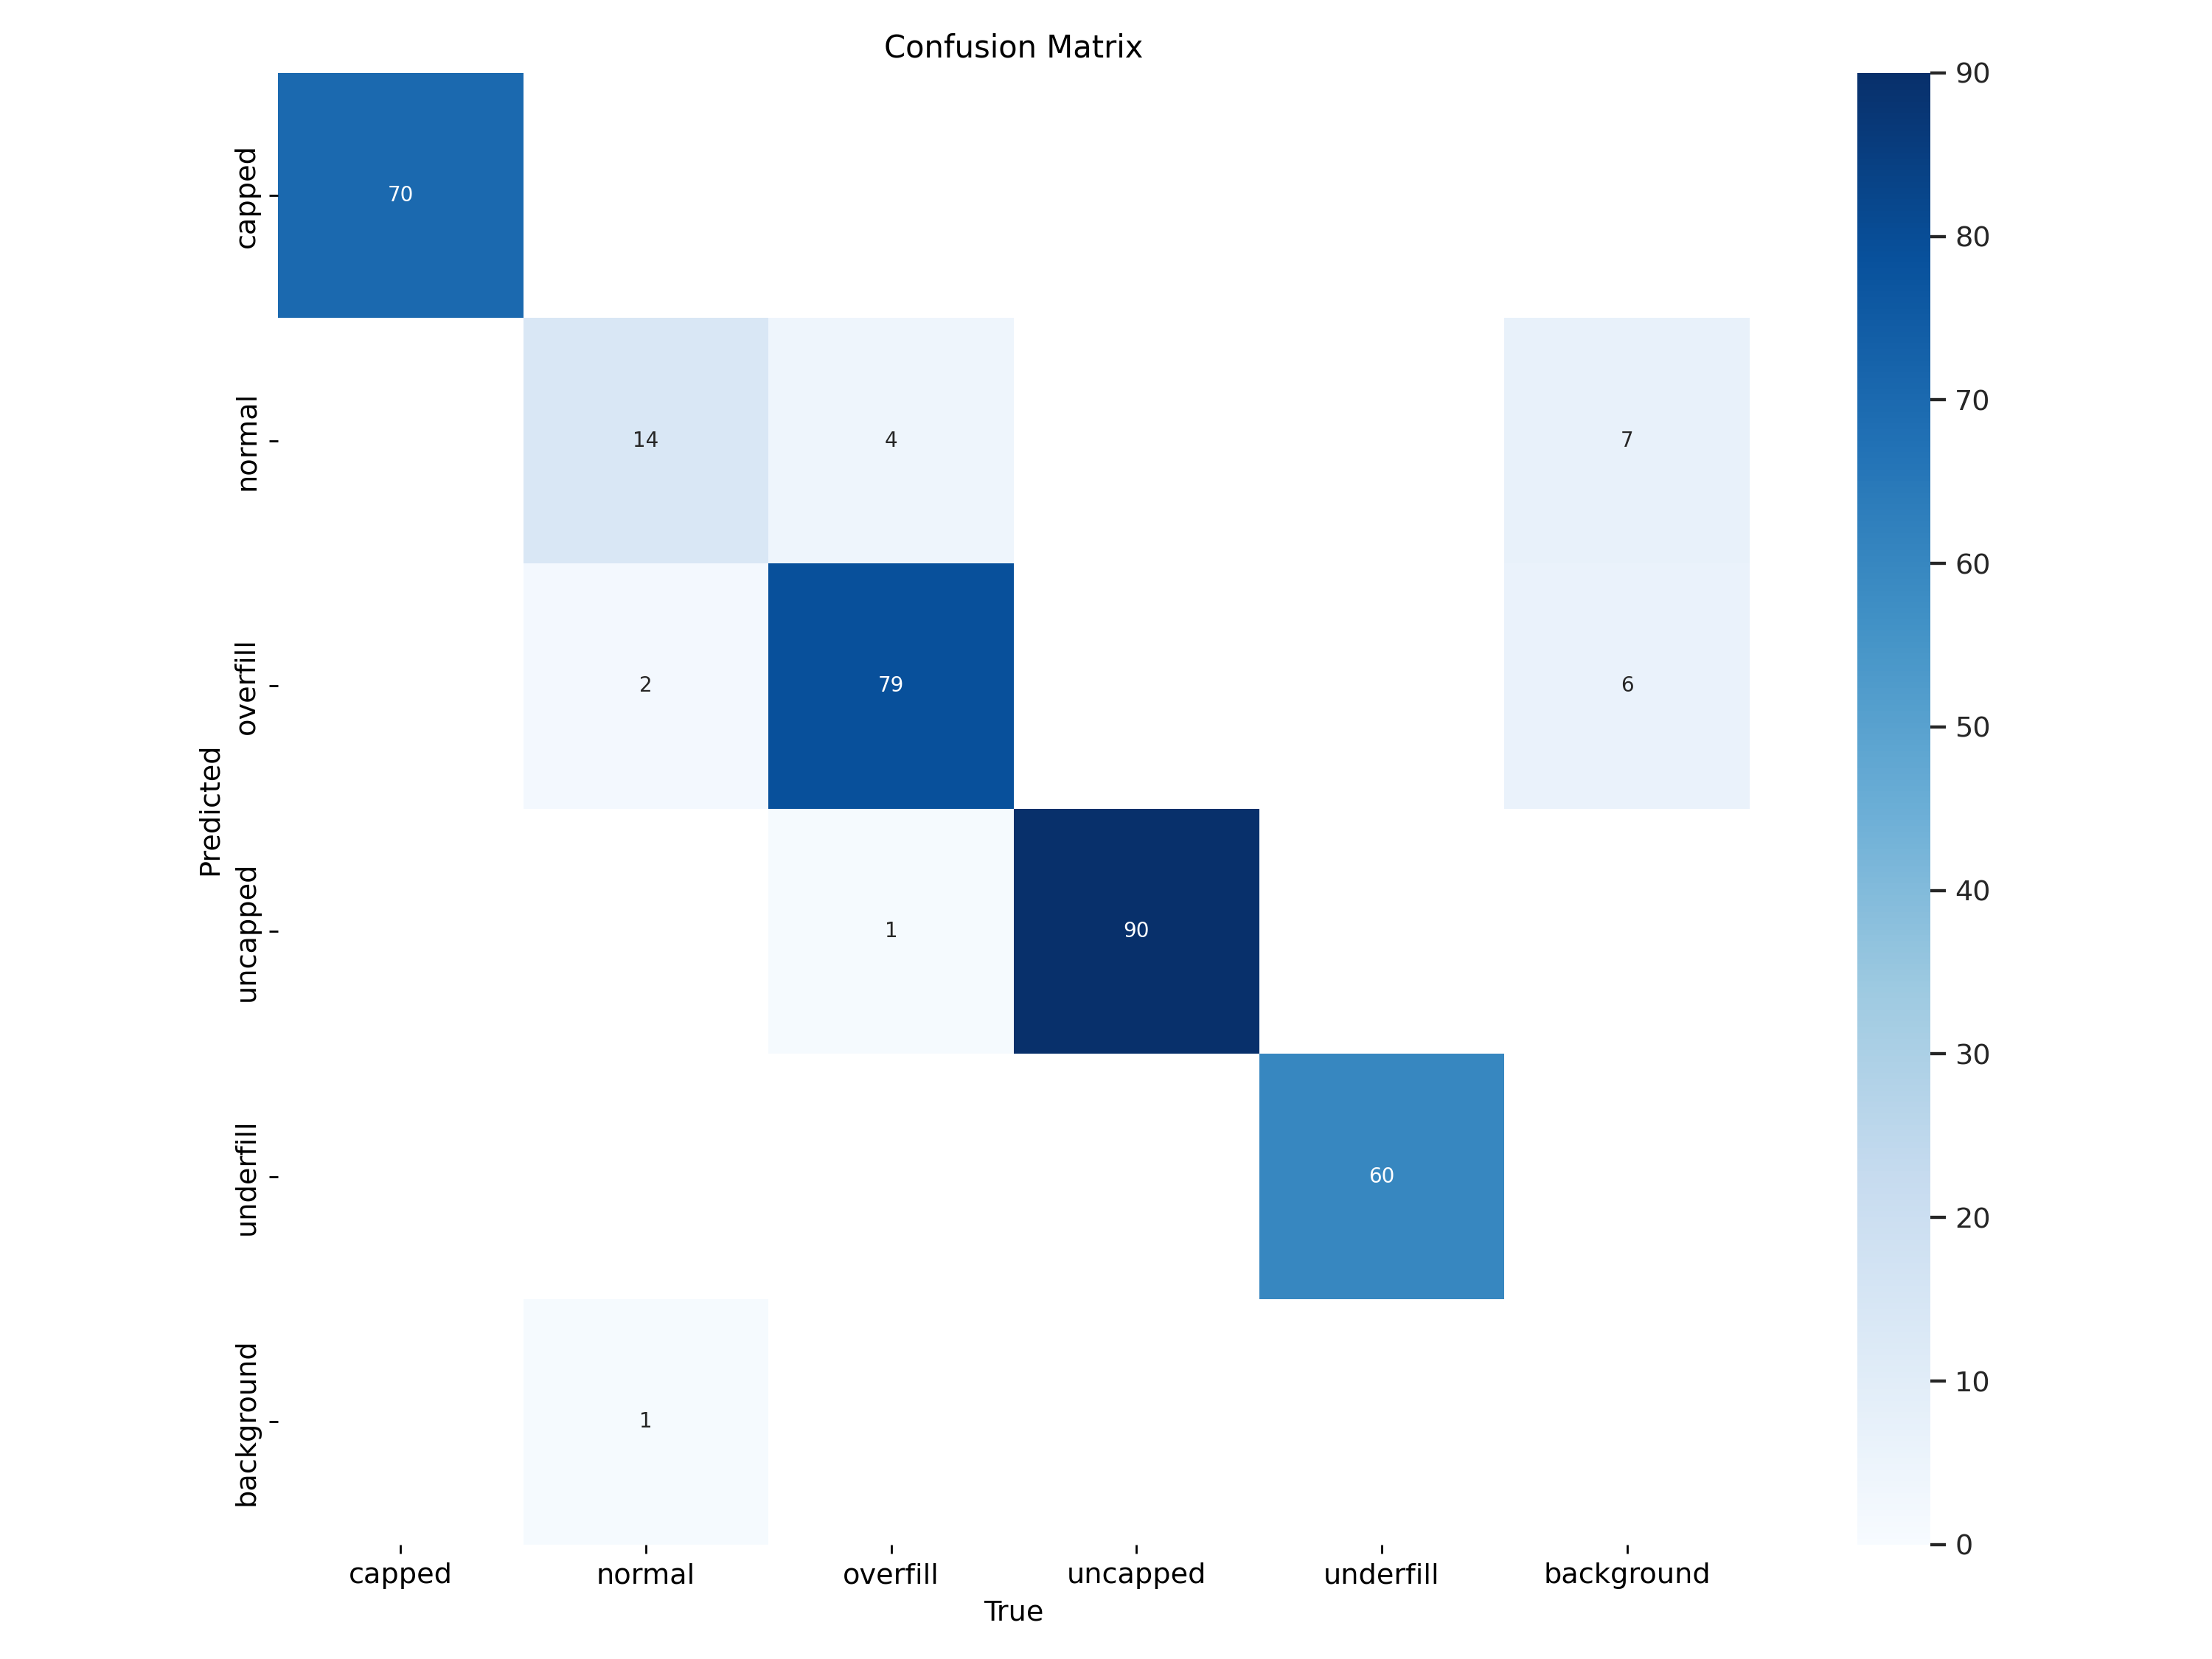

In [8]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'runs/detect/train/confusion_matrix.png', width=600)

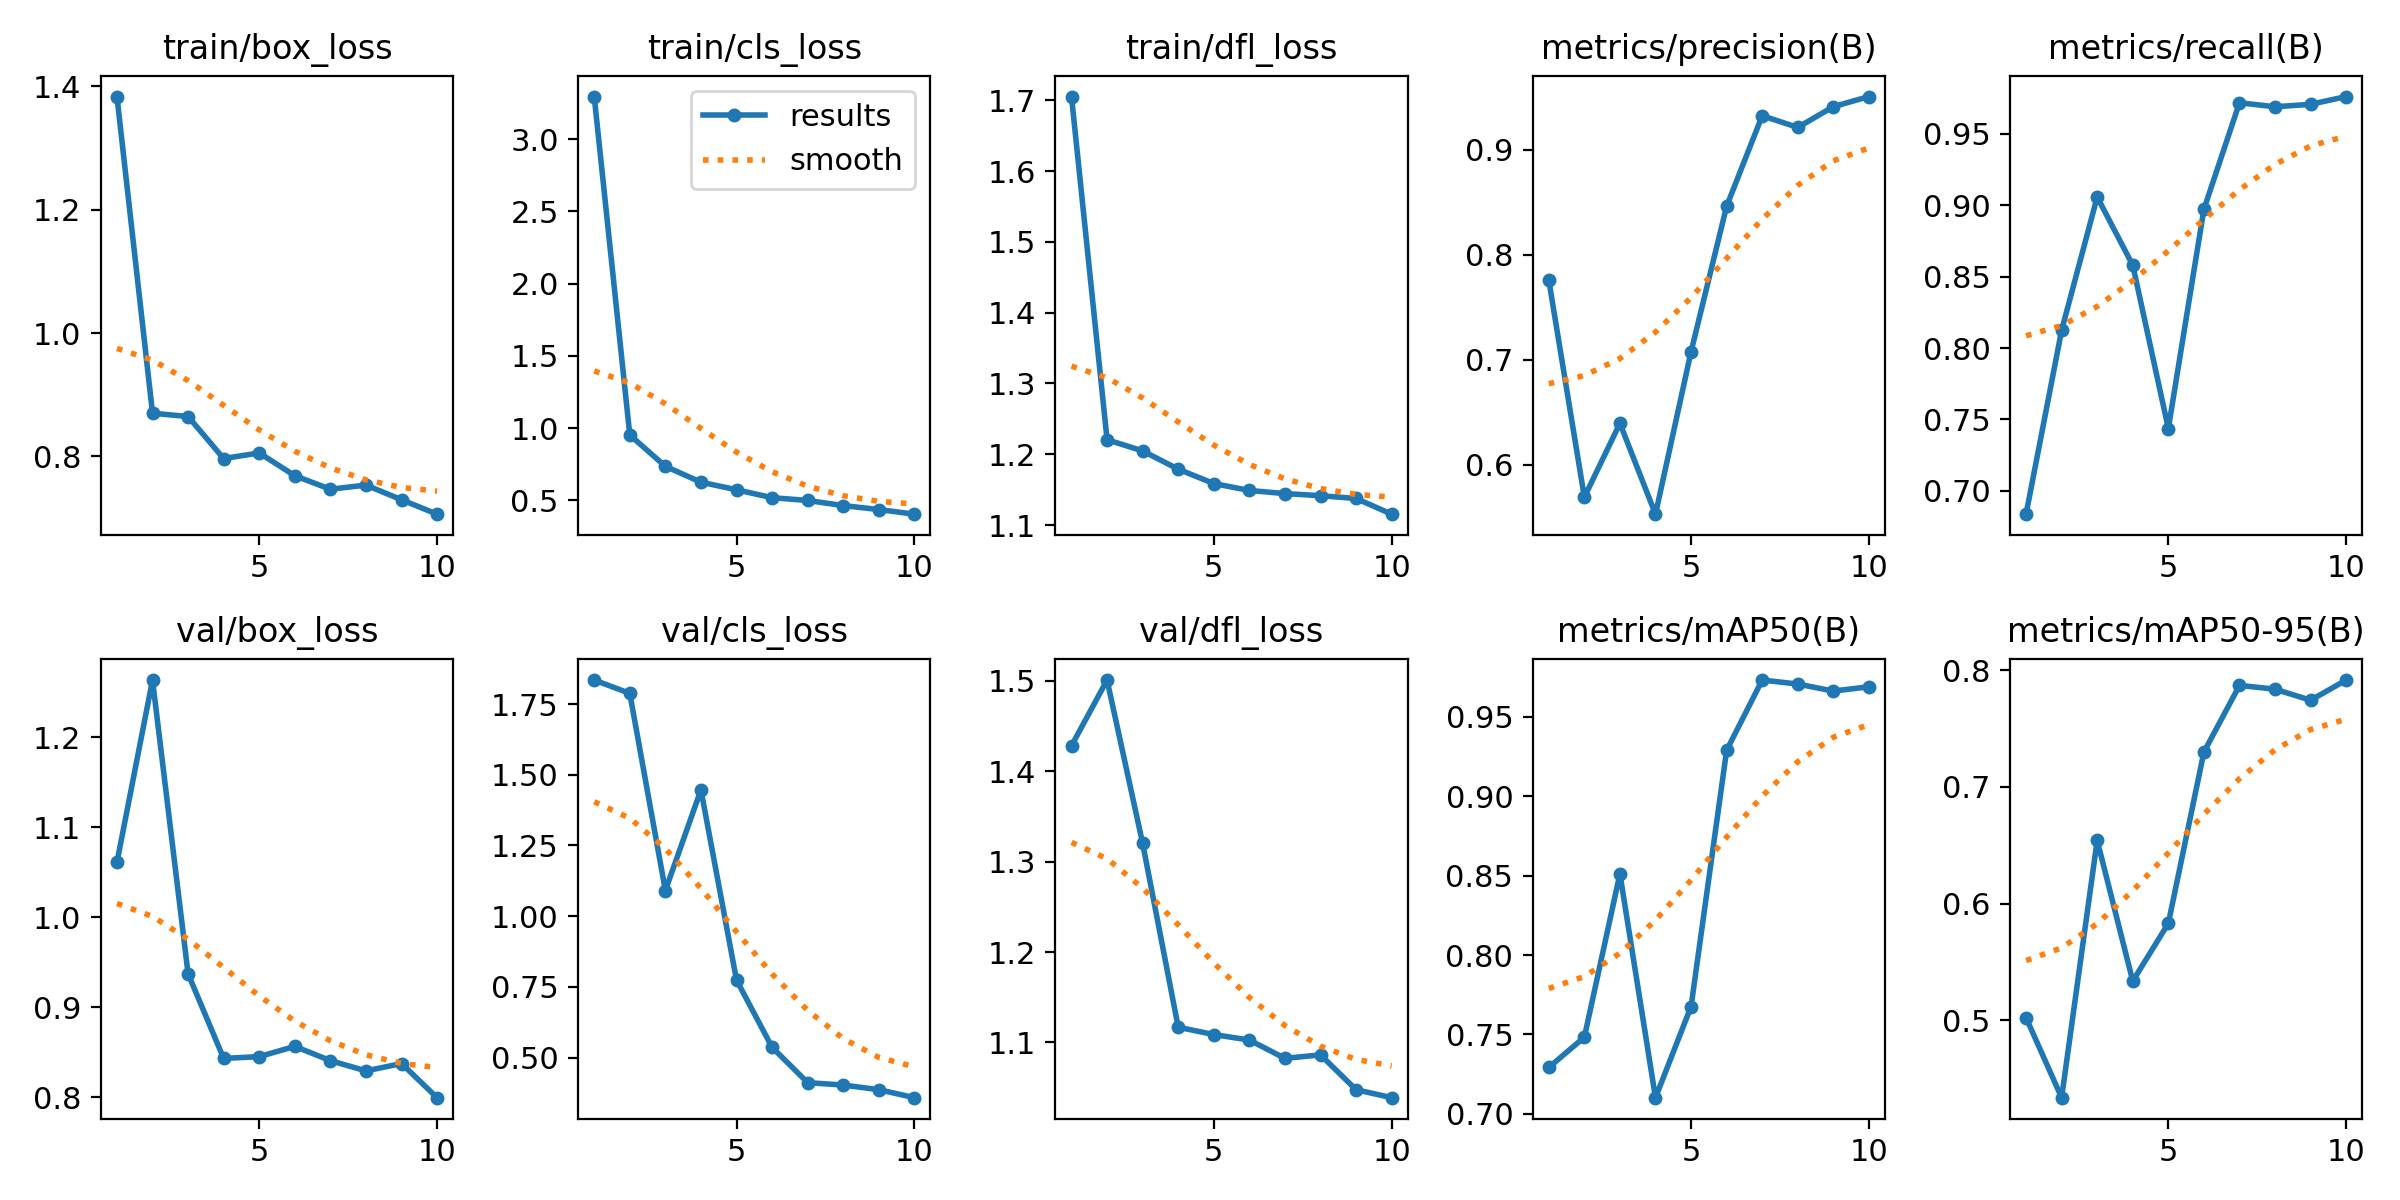

In [9]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'runs/detect/train/results.png', width=600)

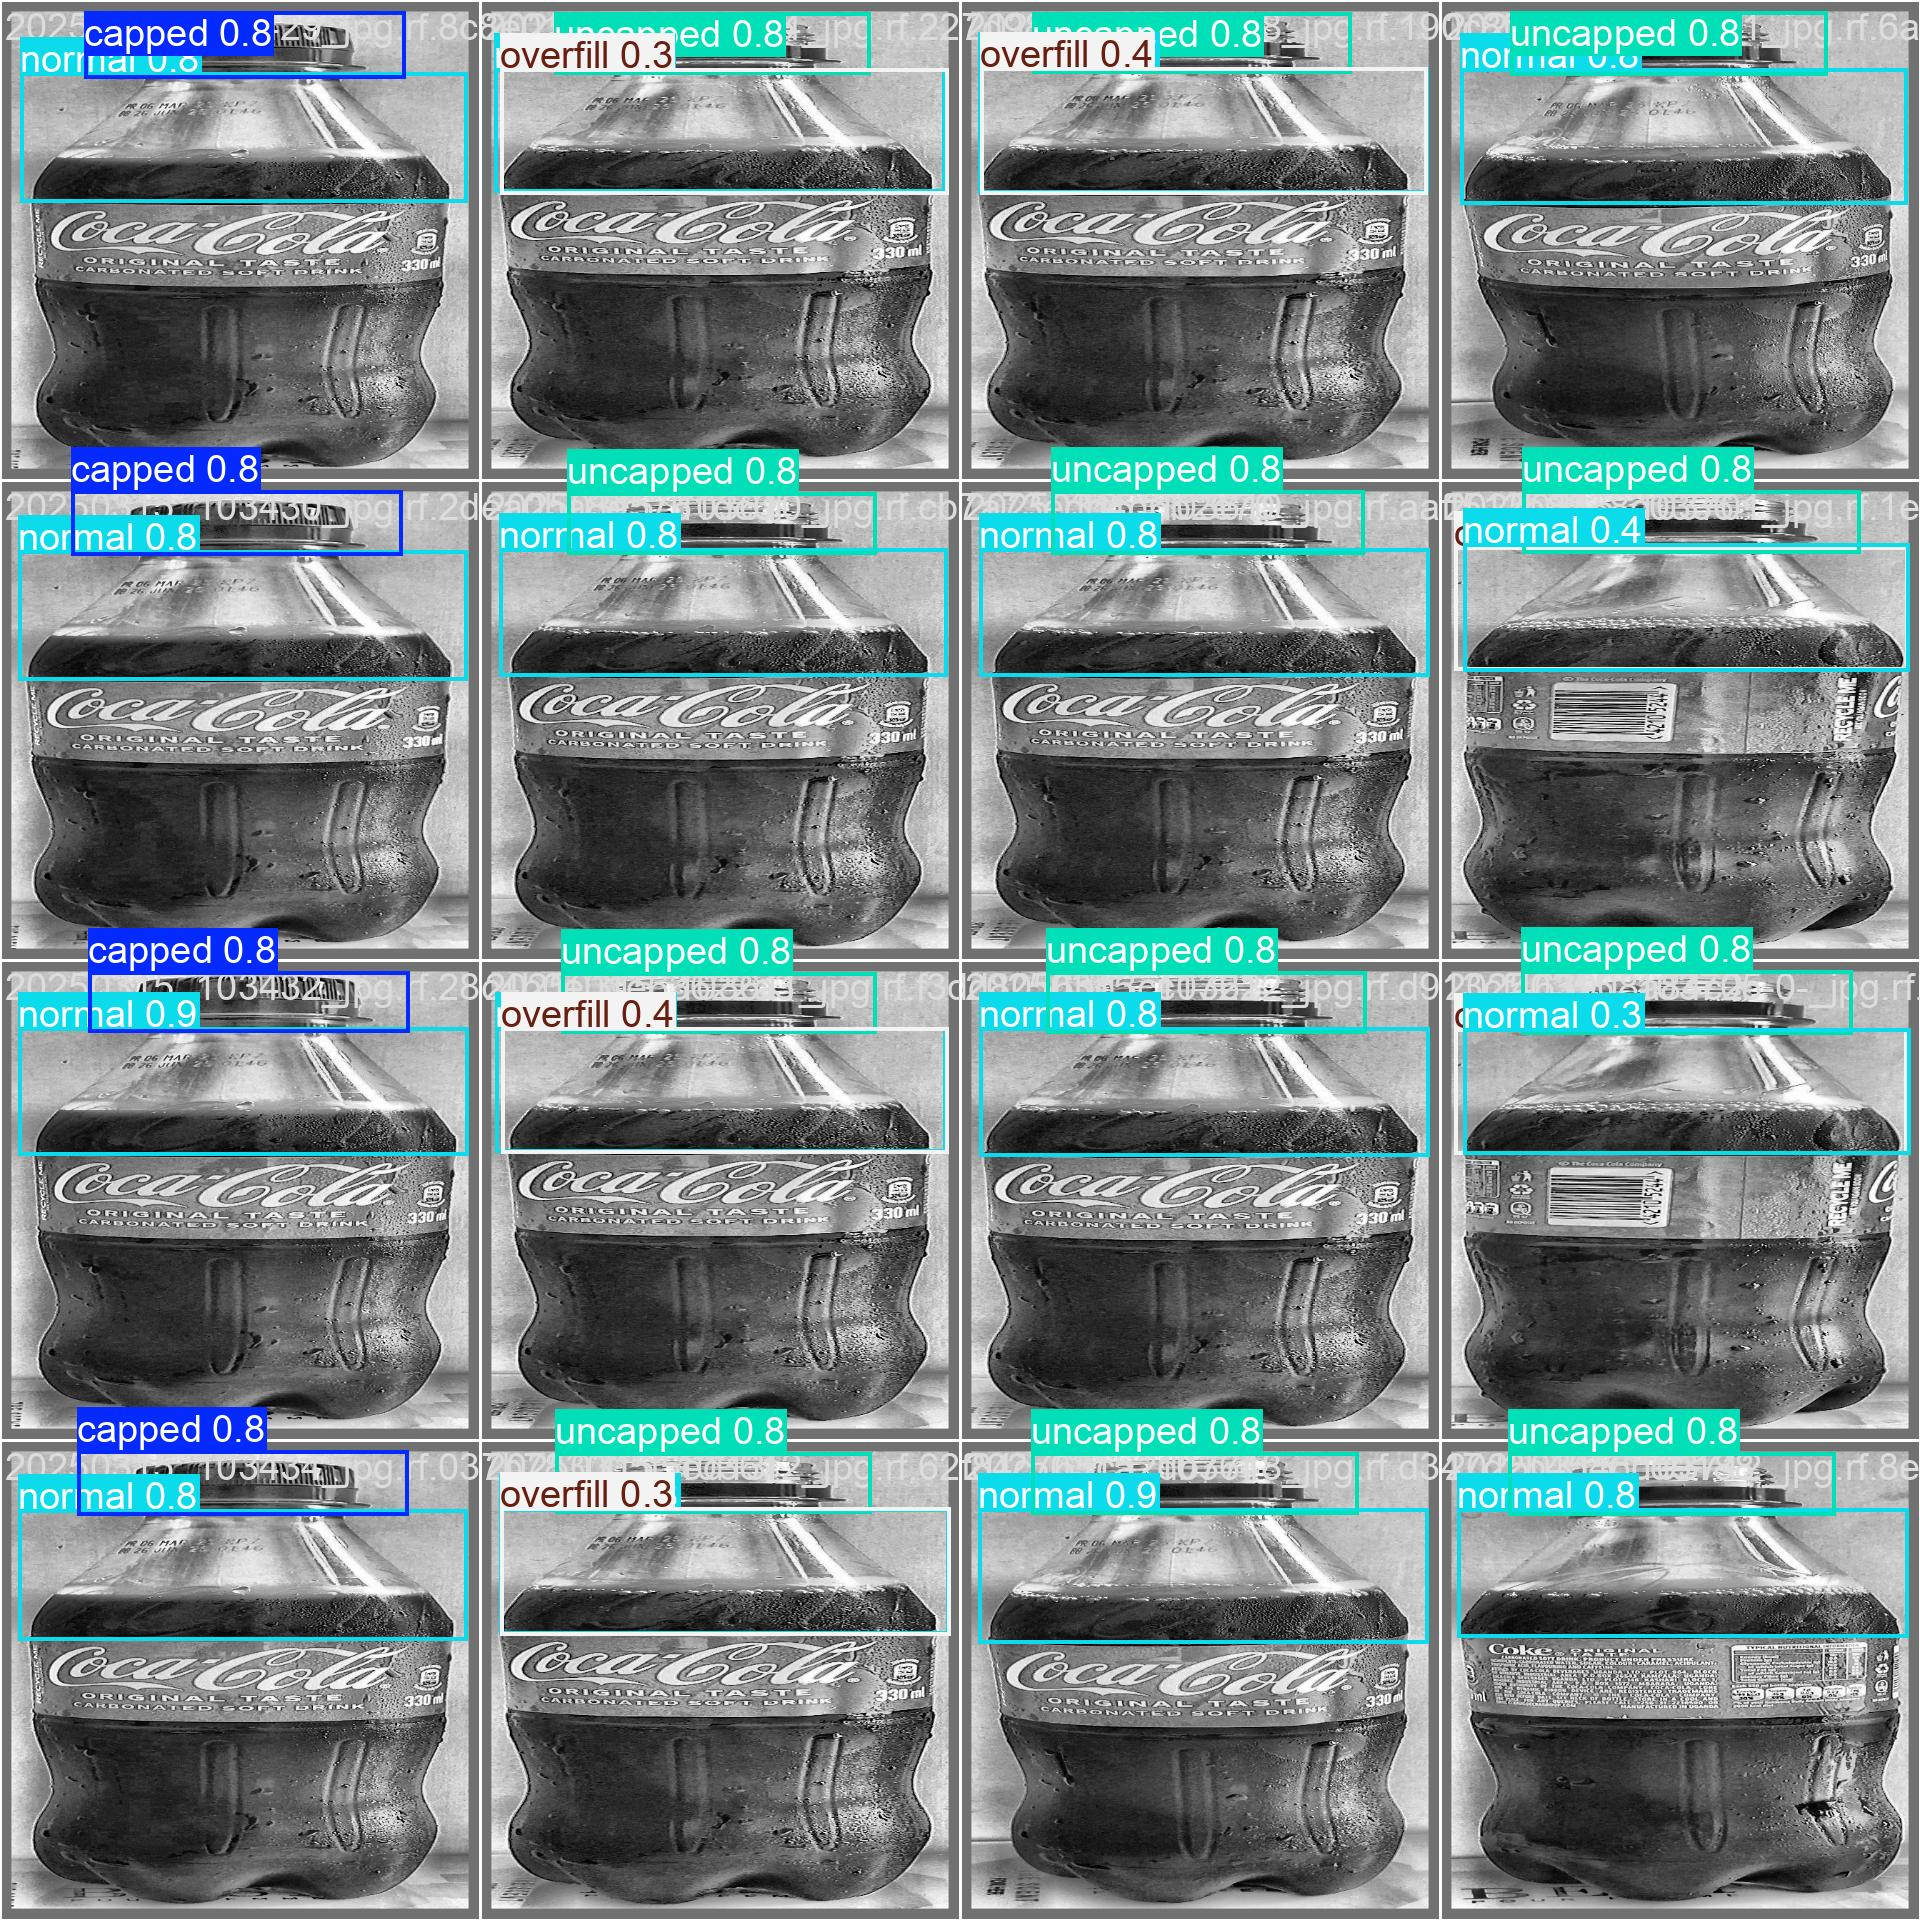

In [10]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [11]:
!yolo task=detect mode=val model=runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/bottle-cap-and-fill-defects-2/valid/labels.cache... 161 images, 0 backgrounds, 0 corrupt: 100% 161/161 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 11/11 [00:04<00:00,  2.57it/s]
                   all        161        321      0.951      0.976      0.969      0.791
                capped         70         70      0.997          1      0.995      0.681
                normal         17         17      0.786      0.941      0.887      0.787
              overfill         84         84      0.987      0.938      0.982      0.885
              uncapped         90         90      0.987          1      0.986      0.699
             underfill         60         60      0.995          1      0.995      0.905
Speed: 4.3ms preproces

## Inference with custom model

In [12]:
!yolo task=detect mode=predict model=runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs

image 1/81 /content/datasets/bottle-cap-and-fill-defects-2/test/images/20250315_103431_jpg.rf.d99a2d41768cebf8121913697ebb7d51.jpg: 640x640 1 capped, 1 normal, 16.2ms
image 2/81 /content/datasets/bottle-cap-and-fill-defects-2/test/images/20250315_103607_jpg.rf.cab84bc153ad7176882b901d11ea107a.jpg: 640x640 1 normal, 1 uncapped, 15.7ms
image 3/81 /content/datasets/bottle-cap-and-fill-defects-2/test/images/20250315_103718_jpg.rf.0697a655ec6ffbb736089678c87a257c.jpg: 640x640 1 normal, 1 uncapped, 18.0ms
image 4/81 /content/datasets/bottle-cap-and-fill-defects-2/test/images/20250315_103729_jpg.rf.6611dbad5265943810f08cd64466cc3d.jpg: 640x640 1 normal, 1 uncapped, 15.6ms
image 5/81 /content/datasets/bottle-cap-and-fill-defects-2/test/images/20250315_103731_jpg.rf.09caf7141a51f166a39d3444444a0505.jpg: 640x640 1 normal, 1 uncappe

**NOTE:** Let's take a look at few results.

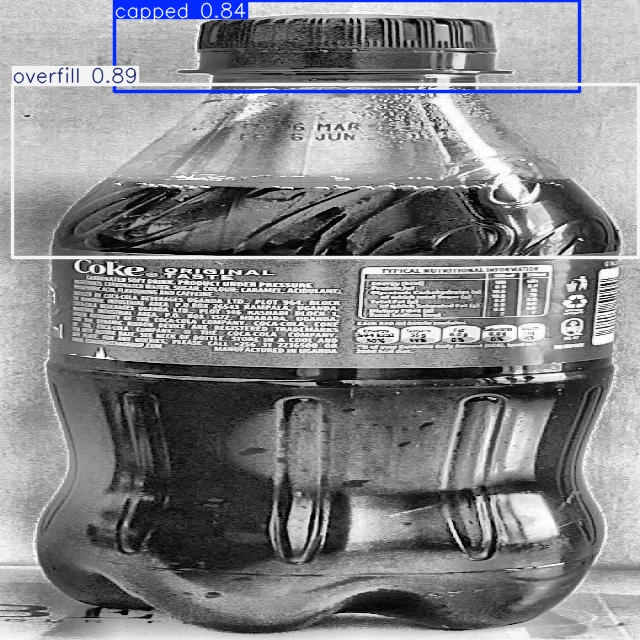

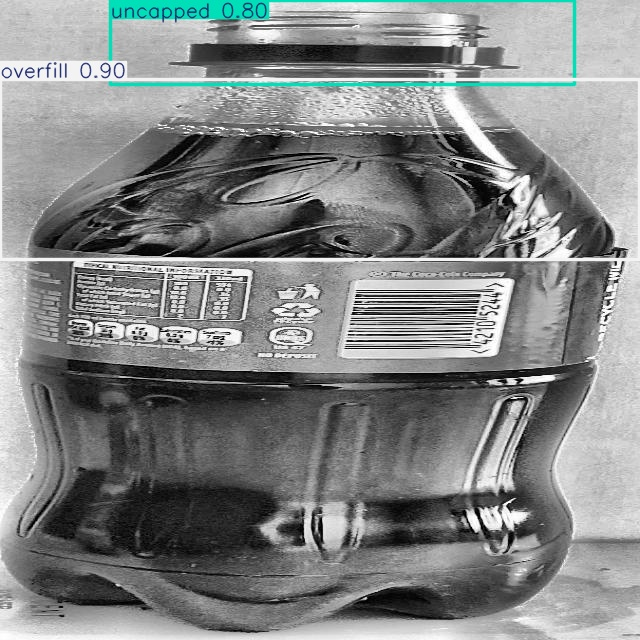

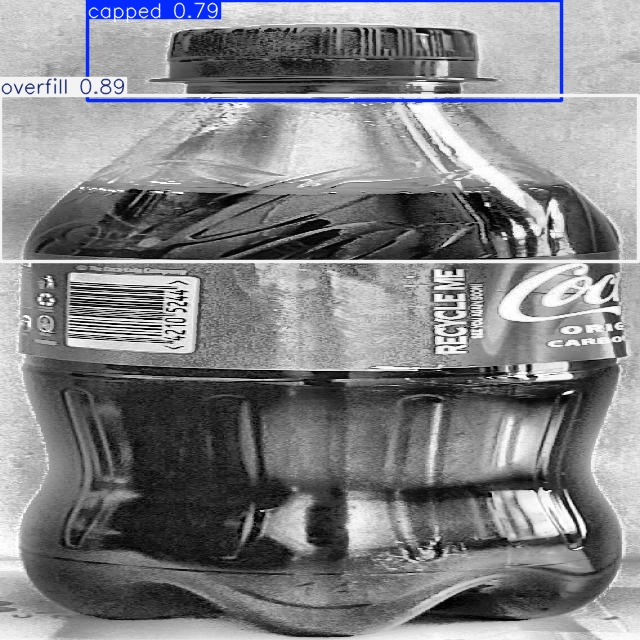

In [13]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Location of the trained Model

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project.